In [2]:
from glob import glob
import pandas as pd
import os
from skimage.io import imread, imsave, imshow
from skimage import img_as_ubyte
from matplotlib import pyplot as plt
from PIL import UnidentifiedImageError
from tqdm import tqdm
import numpy as np
from galaxyteam.dataset import resize_image
from sklearn.model_selection import train_test_split 



In [3]:
train_info_file_path='./data/preprocessed/train_metadata.csv'

full_train = pd.read_csv(train_info_file_path)

train_data, val_data = train_test_split(full_train, 
test_size=0.2,
shuffle=True,
stratify=full_train.is_pneumonia,
random_state=9473)


In [4]:
test_info_file_path='./data/preprocessed/test_metadata.csv'

test_data = pd.read_csv(test_info_file_path)



In [5]:

X_train = [imread(path,as_gray=True) for path in train_data.resized_file_path]
Y_train = np.array([pnu for pnu in train_data.is_pneumonia])
X_val = [imread(path,as_gray=True) for path in val_data.resized_file_path]
Y_val = np.array([pnu for pnu in val_data.is_pneumonia])
X_test = [imread(path,as_gray=True) for path in test_data.resized_file_path]
Y_test = np.array([pnu for pnu in test_data.is_pneumonia])


In [6]:
np.shape(X_train)

(3748, 224, 224)

In [7]:
from builtins import range
from builtins import object


# Reshape the image data into rows
X_train = np.reshape(X_train, (np.shape(X_train)[0], -1))
X_test = np.reshape(X_test, (np.shape(X_test)[0], -1))
X_val = np.reshape(X_val, (np.shape(X_val)[0], -1))

print("X_train: "+str(np.shape(X_train)))
print("X_test: "+str(np.shape(X_test)))
print("X_val: "+str(np.shape(X_val)))

X_train: (3748, 50176)
X_test: (1171, 50176)
X_val: (937, 50176)


In [8]:
class KNearestNeighbor(object):
    """ a kNN classifier with L2 distance """

    def __init__(self):
        pass

    def predict_label(self, dists, k=1):
        num_test = np.shape(dists)[0]
        y_pred = np.zeros(num_test)
        for i in range(num_test):
            closest_y = []
            closest_y = self.y_train[np.argsort(dists[i])][0:k]
            y_pred[i] = np.bincount(closest_y).argmax()
        return y_pred

    def train(self, X, y):
        """
        Train the classifier. For k-nearest neighbors this is just
        memorizing the training data.

        Inputs:
        - X: A numpy array of shape (num_train, D) containing the training data
          consisting of num_train samples each of dimension D.
        - y: A numpy array of shape (N,) containing the training labels, where
             y[i] is the label for X[i].
        """
        self.X_train = X
        self.y_train = y

    def predict(self, X, k=1):
        """
        Predict labels for test data using this classifier.

        Inputs:
        - X: A numpy array of shape (num_test, D) containing test data consisting
             of num_test samples each of dimension D.
        - k: The number of nearest neighbors that vote for the predicted labels.
        - num_loops: Determines which implementation to use to compute distances
          between training points and testing points.

        Returns:
        - y: A numpy array of shape (num_test,) containing predicted labels for the
          test data, where y[i] is the predicted label for the test point X[i].
        """
        dists = self.compute_distances_no_loops(X)

        return self.predict_labels(dists, k=k)

    def compute_distances_no_loops(self, X):
        """
        Compute the distance between each test point in X and each training point
        in self.X_train using no explicit loops.

        Input / Output: Same as compute_distances_two_loops
        """
        num_test = np.shape(X)[0]
        num_train =np.shape( self.X_train)[0]
        dists = np.zeros((num_test, num_train))
        #########################################################################
        dists = np.sqrt(np.power(X,2).sum(axis=1, keepdims  =1) + np.power(self.X_train,2 ).sum(axis=1) - 2 *(np.dot( X,np.transpose(self.X_train))))
        return dists

    def predict_labels(self, dists, k=1):
        """
        Given a matrix of distances between test points and training points,
        predict a label for each test point.

        Inputs:
        - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
          gives the distance betwen the ith test point and the jth training point.

        Returns:
        - y: A numpy array of shape (num_test,) containing predicted labels for the
          test data, where y[i] is the predicted label for the test point X[i].
        """
        num_test = np.shape(dists)[0]
        y_pred = np.zeros(num_test)
        for i in range(num_test):
            # A list of length k storing the labels of the k nearest neighbors to
            # the ith test point.
            closest_y = []
            closest_y = self.y_train[np.argsort(dists[i])][0:k]
            closest_y = closest_y.astype(int)
            y_pred[i] = np.bincount(closest_y).argmax()
        return y_pred

In [9]:
print("Val Accuracy for k=1")
classifier = KNearestNeighbor()
classifier.train(X_train, Y_train)
dists = classifier.compute_distances_no_loops(X_val)
Y_val_pred = classifier.predict_labels(dists, k=1)
num_correct = np.sum(Y_val_pred == Y_val)


Val Accuracy for k=1


C:\Users\beher\AppData\Local\Temp\ipykernel_17928\3632573695.py:60: RuntimeWarning: invalid value encountered in sqrt
  dists = np.sqrt(np.power(X,2).sum(axis=1, keepdims=1) + np.power(self.X_train,2 ).sum(axis=1) - 2 *(np.dot( X,np.transpose(self.X_train))))


In [10]:
num_val = np.shape(X_val)[0]
accuracy = float(num_correct) / num_val
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_val, accuracy))


Got 845 / 937 correct => accuracy: 0.901814


Using SKLEARN


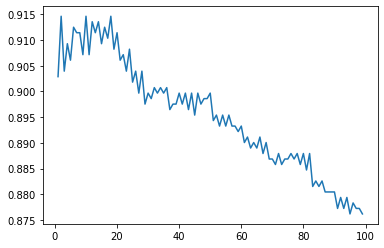

max acc at k=2 acc of 0.9146211312700107


In [11]:
print("Using SKLEARN")
lix = []
liy = []
index=0
acc=0
from sklearn.neighbors import KNeighborsClassifier
for k in range(1, 100):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, Y_train)
    liy.append(neigh.score(X_val, Y_val))
    if liy[k-1]>acc:
        acc=liy[k-1]
        index=k-1
    lix.append(k)

plt.plot(lix, liy)
plt.show()
print("max acc at k="+str(index+1)+" acc of "+str(acc))

In [12]:
neigh = KNeighborsClassifier(n_neighbors=2)
neigh.fit(X_train, Y_train)
print("Test Accuracy: "+str(neigh.score(X_test, Y_test)))

print("Using our own k-NN")
classifier = KNearestNeighbor()
classifier.train(X_train, Y_train)
dists = classifier.compute_distances_no_loops(X_test)
Y_test_pred = classifier.predict_labels(dists, k=2)
num_correct = np.sum(Y_test_pred == Y_test)
num_test= np.shape(X_test)[0]
accuracy = float(num_correct) / num_test
print('With k = 2 Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Test Accuracy: 0.9128949615713066
Using our own k-NN
With k = 2 Got 1069 / 1171 correct => accuracy: 0.912895


In [14]:
from sklearn.metrics import accuracy_score, confusion_matrix


cm = confusion_matrix(Y_test, Y_test_pred)
tn, fp, fn, tp = cm.ravel()



print('\nTESTING METRICS')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(accuracy))
print('Precision: {}%'.format(precision))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))
print('Recall: {}%'.format(recall))


TESTING METRICS
Accuracy: 0.9128949615713066%
Precision: 93.89830508474576%
F1-score: 94.21768707482991
Recall: 94.53924914675767%


Using SKLEARN


C:\Users\beher\AppData\Local\Temp\ipykernel_17928\3632573695.py:60: RuntimeWarning: invalid value encountered in sqrt
  dists = np.sqrt(np.power(X,2).sum(axis=1, keepdims=1) + np.power(self.X_train,2 ).sum(axis=1) - 2 *(np.dot( X,np.transpose(self.X_train))))
C:\Users\beher\AppData\Local\Temp\ipykernel_17928\3632573695.py:60: RuntimeWarning: invalid value encountered in sqrt
  dists = np.sqrt(np.power(X,2).sum(axis=1, keepdims=1) + np.power(self.X_train,2 ).sum(axis=1) - 2 *(np.dot( X,np.transpose(self.X_train))))
C:\Users\beher\AppData\Local\Temp\ipykernel_17928\3632573695.py:60: RuntimeWarning: invalid value encountered in sqrt
  dists = np.sqrt(np.power(X,2).sum(axis=1, keepdims=1) + np.power(self.X_train,2 ).sum(axis=1) - 2 *(np.dot( X,np.transpose(self.X_train))))
C:\Users\beher\AppData\Local\Temp\ipykernel_17928\3632573695.py:60: RuntimeWarning: invalid value encountered in sqrt
  dists = np.sqrt(np.power(X,2).sum(axis=1, keepdims=1) + np.power(self.X_train,2 ).sum(axis=1) - 2 *(

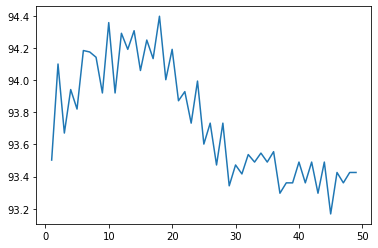

max f1 at k=18 acc of 94.39775910364145


In [22]:
lix = []
liy = []
index=0
f1=0
from sklearn.neighbors import KNeighborsClassifier
for k in range(1, 50):
    classifier = KNearestNeighbor()
    classifier.train(X_train, Y_train)
    dists = classifier.compute_distances_no_loops(X_val)
    Y_val_pred = classifier.predict_labels(dists, k)  
    
    cm = confusion_matrix(Y_val, Y_val_pred)
    tn, fp, fn, tp = cm.ravel()
    precision = tp/(tp+fp)*100
    recall = tp/(tp+fn)*100
    liy.append(2*precision*recall/(precision+recall))
    if liy[k-1]>f1:
        f1=liy[k-1]
        index=k-1
    lix.append(k)

plt.plot(lix, liy)
plt.show()
print("max f1 at k="+str(index+1)+" acc of "+str(f1))

CONFUSION MATRIX


<Figure size 432x288 with 0 Axes>

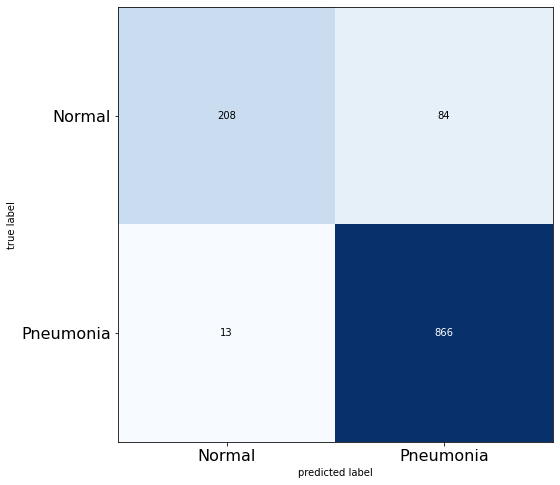


TESTING METRICS
Accuracy: 0.9171648163962425%
Precision: 91.15789473684211%
F1-score: 94.6965554948059
Recall: 98.52104664391354%


In [30]:
from sklearn.metrics import accuracy_score, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
neigh = KNeighborsClassifier(n_neighbors=18)
neigh.fit(X_train, Y_train)



classifier = KNearestNeighbor()
classifier.train(X_train, Y_train)
dists = classifier.compute_distances_no_loops(X_test)
Y_test_pred = classifier.predict_labels(dists, k=18)
num_correct = np.sum(Y_test_pred == Y_test)
num_test= np.shape(X_test)[0]
accuracy = float(num_correct) / num_test

cm = confusion_matrix(Y_test, Y_test_pred)
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX')
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

print('\nTESTING METRICS')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(accuracy))
print('Precision: {}%'.format(precision))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))
print('Recall: {}%'.format(recall))